# Digit recognizer

In [38]:
### Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from time import time
tf.logging.set_verbosity(tf.logging.INFO) # DEBUG,WARN,INFO,FATAL,ERROR

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [65]:
### Importing MNIST dataset
train=pd.read_csv("train.csv")
train=train.astype(float)
test=pd.read_csv("test.csv")
test=test.astype(float)

In [74]:
### Splitting the training data
evl=train.iloc[0:100,:]
evl2=train.iloc[100:200,:]

### Splitting labels and features
evl_l=evl["label"].astype(int)
evl_f=evl.iloc[:,1:]

evl2_l=evl2["label"].astype(int)
evl2_f=evl2.iloc[:,1:]

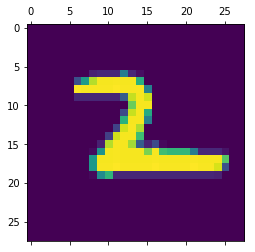

In [41]:
### Showing random example
random=np.random.randint(len(evl_f)-1)
_, ax = plt.subplots()
ax.matshow(evl_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

### Convolutional neural network

In [44]:
feature_column=[tf.feature_column.numeric_column(key="pixels",shape=[784])]

In [121]:
def my_model(features,labels,mode):
    input_layer= tf.reshape(features["pixels"], [-1, 28, 28, 1])
    conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=(5,5),padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=10)
    predicted_classes = tf.argmax(logits, 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits, name="softmax_tensor"),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
        labels=labels, predictions=predictions["classes"])
    }   
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

    


In [115]:
clf=tf.estimator.Estimator(model_fn=my_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Steven\\AppData\\Local\\Temp\\tmpmgma70et', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002D1D24D2160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [120]:
train_input_fn=create_training_input_fn(features2=evl_f,labels2=evl_l,batch_size=5)
clf.train(input_fn=train_input_fn,steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Steven\AppData\Local\Temp\tmpmgma70et\model.ckpt.
INFO:tensorflow:loss = 26.435455322265625, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Steven\AppData\Local\Temp\tmpmgma70et\model.ckpt.
INFO:tensorflow:Loss for final step: 0.5639075040817261.


In [122]:
predict_input_fn=create_predict_input_fn(evl2_f,evl2_l,1)

In [123]:
pred=clf.predict(input_fn=predict_input_fn)

In [124]:
outcome=[]
for i in pred:
    outcome.append(i["class_ids"][0])
outcome=np.array(outcome)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Steven\AppData\Local\Temp\tmpmgma70et\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [125]:
outcome

array([9, 2, 9, 7, 6, 8, 9, 5, 0, 6, 0, 6, 3, 9, 0, 7, 7, 1, 1, 6, 6, 9,
       4, 6, 1, 0, 9, 6, 0, 0, 4, 6, 2, 6, 1, 1, 7, 3, 7, 3, 1, 0, 3, 6,
       5, 4, 0, 0, 9, 0, 3, 5, 1, 0, 6, 3, 7, 0, 9, 6, 6, 9, 5, 9, 1, 9,
       9, 3, 4, 2, 9, 8, 2, 1, 5, 2, 2, 0, 2, 5, 9, 3, 1, 2, 4, 1, 6, 9,
       0, 6, 1, 9, 9, 3, 6, 0, 6, 2, 3, 6], dtype=int64)

In [126]:
evl2_l

100    9
101    2
102    7
103    7
104    2
      ..
195    0
196    0
197    8
198    3
199    2
Name: label, Length: 100, dtype: int32

In [127]:
metrics.accuracy_score(evl2_l,outcome)

0.61

### Linear classifier

In [6]:
def create_training_input_fn(features2,labels2,batch_size,epochs=None):
    def _input_fn():
        idx=np.random.permutation(features2.index.values)
        features=features2.reindex(idx)
        features={"pixels":features}
        labels=np.array(labels2[idx])
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size).repeat(epochs)
        ds=ds.shuffle(40000)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [7]:
def create_predict_input_fn(features2,labels2,batch_size):
    def _input_fn():
        features={"pixels":features2}
        labels=np.array(labels2)
        
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [8]:
def train_linear_classifier(train_f,train_l,pred_f,pred_l,batch_size,steps,learning_rate,periods):
    training_input_fn=create_training_input_fn(train_f,train_l,batch_size=batch_size)
    predict_input_fn=create_predict_input_fn(evl2_f,evl2_l,batch_size=1)
    a=time()
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate)
    classifier=tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), 
                                         n_classes=10, 
                                         optimizer=optimizer,
                                         config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    steps_per=steps/periods
    print("Time to create classifier: %f" % (time()-a))
    for i in range(periods):
        classifier.train(input_fn=training_input_fn,steps=steps_per)
        print("Time to train: %f" %(time()-a))
        pred=classifier.predict(input_fn=predict_input_fn)
        pred2=np.array([item["class_ids"][0] for item in pred])
        print("Time to predict: %f" %(time()-a))
        
        print(metrics.accuracy_score(np.array(evl2_l),pred2))
    
    return classifier

In [11]:
classifier=train_linear_classifier(train_f=evl_f,
                                   train_l=evl_l,
                                   pred_f=evl2_f,
                                   pred_l=evl2_l,
                                   batch_size=30,
                                   steps=500,
                                   learning_rate=0.01,
                                   periods=4)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Steven\\AppData\\Local\\Temp\\tmpkvradeen', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002D1D0E79DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Time to create classifier: 0.062502
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Steven\App